In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
import seaborn as sns

from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

import datetime

C:\ProgramData\miniconda3\envs\dsi-sg\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_east = pd.read_csv('../data/df_east_merge.csv')

In [3]:
df_east.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 392 non-null    int64  
 1   yr                         392 non-null    int64  
 2   week                       392 non-null    int64  
 3   region                     392 non-null    object 
 4   no_cases                   392 non-null    int64  
 5   total_daily_rainfall       392 non-null    float64
 6   max_wind_sp                392 non-null    float64
 7   max_temp                   392 non-null    float64
 8   rainy_day                  392 non-null    int64  
 9   mean_temp                  392 non-null    float64
 10  mean_wind_sp               392 non-null    float64
 11  min_temp                   392 non-null    float64
 12  dengue_fever               392 non-null    float64
 13  dengue                     392 non-null    float64

In [4]:
df_east.head()

,Unnamed: 0,yr,week,region,no_cases,total_daily_rainfall,max_wind_sp,max_temp,rainy_day,mean_temp,...,mosquito,insect_repellent,dengue_fever_diff,dengue_fever_2nd_diff,dengue_diff,dengue_2nd_diff,mosquito_diff,mosquito_2nd_diff,insect_repellent_diff,insect_repellent_2nd_diff
0,0,2013,21,East,283,38.6,45.7,33.4,1,28.3,...,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2013,22,East,278,87.4,38.5,33.1,1,27.7,...,9.0,3.0,-4.0,0.0,-2.0,0.0,-1.0,0.0,1.0,0.0
2,2,2013,23,East,140,177.4,46.1,33.7,1,27.8,...,18.0,4.0,27.0,31.0,24.0,26.0,9.0,10.0,1.0,0.0
3,3,2013,24,East,446,33.0,87.1,33.6,1,29.7,...,14.0,2.0,-14.0,-41.0,-13.0,-37.0,-4.0,-13.0,-2.0,-3.0
4,4,2013,25,East,481,0.2,43.6,34.5,1,30.0,...,8.0,2.0,-17.0,-3.0,-16.0,-3.0,-6.0,-2.0,0.0,2.0


In [5]:
df_east['index'] = df_east['yr'] * 100 + df_east['week']
df_east.tail()

,Unnamed: 0,yr,week,region,no_cases,total_daily_rainfall,max_wind_sp,max_temp,rainy_day,mean_temp,...,insect_repellent,dengue_fever_diff,dengue_fever_2nd_diff,dengue_diff,dengue_2nd_diff,mosquito_diff,mosquito_2nd_diff,insect_repellent_diff,insect_repellent_2nd_diff,index
387,387,2020,41,East,140,49.0,52.2,33.2,1,28.1,...,3.0,1.0,3.0,2.0,4.0,0.0,-1.0,0.0,1.0,202041
388,388,2020,42,East,140,14.2,51.5,33.6,1,28.8,...,3.0,-2.0,-3.0,-1.0,-3.0,-2.0,-2.0,0.0,0.0,202042
389,389,2020,43,East,140,41.8,57.2,33.7,1,28.2,...,2.0,-1.0,1.0,-2.0,-1.0,2.0,4.0,-1.0,-1.0,202043
390,390,2020,44,East,140,47.2,37.8,34.1,1,28.1,...,1.0,-1.0,0.0,-1.0,1.0,-4.0,-6.0,-1.0,0.0,202044
391,391,2020,45,East,619,239.4,45.0,32.7,1,27.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202045


In [6]:
# convert the integer column to a datetime index
df_east['index'] = pd.to_datetime(df_east['index'].astype(str) + '-0', format='%Y%W-%w')

In [7]:
df_east.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Unnamed: 0                 392 non-null    int64         
 1   yr                         392 non-null    int64         
 2   week                       392 non-null    int64         
 3   region                     392 non-null    object        
 4   no_cases                   392 non-null    int64         
 5   total_daily_rainfall       392 non-null    float64       
 6   max_wind_sp                392 non-null    float64       
 7   max_temp                   392 non-null    float64       
 8   rainy_day                  392 non-null    int64         
 9   mean_temp                  392 non-null    float64       
 10  mean_wind_sp               392 non-null    float64       
 11  min_temp                   392 non-null    float64       
 12  dengue_f

In [8]:

df_east = df_east.set_index('index')
df_east.tail()

,Unnamed: 0,yr,week,region,no_cases,total_daily_rainfall,max_wind_sp,max_temp,rainy_day,mean_temp,...,mosquito,insect_repellent,dengue_fever_diff,dengue_fever_2nd_diff,dengue_diff,dengue_2nd_diff,mosquito_diff,mosquito_2nd_diff,insect_repellent_diff,insect_repellent_2nd_diff
index,,,,,,,,,,,,,,,,,,,,,
2020-10-18,387,2020,41,East,140,49.0,52.2,33.2,1,28.1,...,10.0,3.0,1.0,3.0,2.0,4.0,0.0,-1.0,0.0,1.0
2020-10-25,388,2020,42,East,140,14.2,51.5,33.6,1,28.8,...,8.0,3.0,-2.0,-3.0,-1.0,-3.0,-2.0,-2.0,0.0,0.0
2020-11-01,389,2020,43,East,140,41.8,57.2,33.7,1,28.2,...,10.0,2.0,-1.0,1.0,-2.0,-1.0,2.0,4.0,-1.0,-1.0
2020-11-08,390,2020,44,East,140,47.2,37.8,34.1,1,28.1,...,6.0,1.0,-1.0,0.0,-1.0,1.0,-4.0,-6.0,-1.0,0.0
2020-11-15,391,2020,45,East,619,239.4,45.0,32.7,1,27.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_east = df_east.loc[~df_east.index.duplicated(), :]

In [10]:
df_east.index.is_unique

True

In [11]:
df_east = df_east.asfreq('W')
print(df_east.index.dtype)
df_east.tail()

datetime64[ns]


,Unnamed: 0,yr,week,region,no_cases,total_daily_rainfall,max_wind_sp,max_temp,rainy_day,mean_temp,...,mosquito,insect_repellent,dengue_fever_diff,dengue_fever_2nd_diff,dengue_diff,dengue_2nd_diff,mosquito_diff,mosquito_2nd_diff,insect_repellent_diff,insect_repellent_2nd_diff
index,,,,,,,,,,,,,,,,,,,,,
2020-10-18,387.0,2020.0,41.0,East,140.0,49.0,52.2,33.2,1.0,28.1,...,10.0,3.0,1.0,3.0,2.0,4.0,0.0,-1.0,0.0,1.0
2020-10-25,388.0,2020.0,42.0,East,140.0,14.2,51.5,33.6,1.0,28.8,...,8.0,3.0,-2.0,-3.0,-1.0,-3.0,-2.0,-2.0,0.0,0.0
2020-11-01,389.0,2020.0,43.0,East,140.0,41.8,57.2,33.7,1.0,28.2,...,10.0,2.0,-1.0,1.0,-2.0,-1.0,2.0,4.0,-1.0,-1.0
2020-11-08,390.0,2020.0,44.0,East,140.0,47.2,37.8,34.1,1.0,28.1,...,6.0,1.0,-1.0,0.0,-1.0,1.0,-4.0,-6.0,-1.0,0.0
2020-11-15,391.0,2020.0,45.0,East,619.0,239.4,45.0,32.7,1.0,27.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
missing_values = df_east.isnull()
rows_with_missing_values = missing_values.any(axis=1)
print(df_east[rows_with_missing_values])

            Unnamed: 0  yr  week region  no_cases  total_daily_rainfall  \
index                                                                     
2019-01-06         NaN NaN   NaN    NaN       NaN                   NaN   

            max_wind_sp  max_temp  rainy_day  mean_temp  ...  mosquito  \
index                                                    ...             
2019-01-06          NaN       NaN        NaN        NaN  ...       NaN   

            insect_repellent  dengue_fever_diff  dengue_fever_2nd_diff  \
index                                                                    
2019-01-06               NaN                NaN                    NaN   

            dengue_diff  dengue_2nd_diff  mosquito_diff  mosquito_2nd_diff  \
index                                                                        
2019-01-06          NaN              NaN            NaN                NaN   

            insect_repellent_diff  insect_repellent_2nd_diff  
index                         

In [13]:
df_east = df_east.fillna(method='ffill')

In [14]:
df_east = df_east.sort_index()
df_east.tail()

,Unnamed: 0,yr,week,region,no_cases,total_daily_rainfall,max_wind_sp,max_temp,rainy_day,mean_temp,...,mosquito,insect_repellent,dengue_fever_diff,dengue_fever_2nd_diff,dengue_diff,dengue_2nd_diff,mosquito_diff,mosquito_2nd_diff,insect_repellent_diff,insect_repellent_2nd_diff
index,,,,,,,,,,,,,,,,,,,,,
2020-10-18,387.0,2020.0,41.0,East,140.0,49.0,52.2,33.2,1.0,28.1,...,10.0,3.0,1.0,3.0,2.0,4.0,0.0,-1.0,0.0,1.0
2020-10-25,388.0,2020.0,42.0,East,140.0,14.2,51.5,33.6,1.0,28.8,...,8.0,3.0,-2.0,-3.0,-1.0,-3.0,-2.0,-2.0,0.0,0.0
2020-11-01,389.0,2020.0,43.0,East,140.0,41.8,57.2,33.7,1.0,28.2,...,10.0,2.0,-1.0,1.0,-2.0,-1.0,2.0,4.0,-1.0,-1.0
2020-11-08,390.0,2020.0,44.0,East,140.0,47.2,37.8,34.1,1.0,28.1,...,6.0,1.0,-1.0,0.0,-1.0,1.0,-4.0,-6.0,-1.0,0.0
2020-11-15,391.0,2020.0,45.0,East,619.0,239.4,45.0,32.7,1.0,27.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
print(f'Number of rows with missing values: {df_east.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [16]:
# Verify that a temporary index is complete
# ==============================================================================
(df_east.index == pd.date_range(start=df_east.index.min(),
                             end=df_east.index.max(),
                             freq=df_east.index.freq)).all()

True

In [17]:
df_east = df_east.drop(['Unnamed: 0','yr','week','region'],axis =1)
df_east

,no_cases,total_daily_rainfall,max_wind_sp,max_temp,rainy_day,mean_temp,mean_wind_sp,min_temp,dengue_fever,dengue,mosquito,insect_repellent,dengue_fever_diff,dengue_fever_2nd_diff,dengue_diff,dengue_2nd_diff,mosquito_diff,mosquito_2nd_diff,insect_repellent_diff,insect_repellent_2nd_diff
index,,,,,,,,,,,,,,,,,,,,
2013-06-02,283.0,38.6,45.7,33.4,1.0,28.3,7.100000,23.9,33.0,30.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-06-09,278.0,87.4,38.5,33.1,1.0,27.7,6.500000,22.6,29.0,28.0,9.0,3.0,-4.0,0.0,-2.0,0.0,-1.0,0.0,1.0,0.0
2013-06-16,140.0,177.4,46.1,33.7,1.0,27.8,7.092857,22.9,56.0,52.0,18.0,4.0,27.0,31.0,24.0,26.0,9.0,10.0,1.0,0.0
2013-06-23,446.0,33.0,87.1,33.6,1.0,29.7,9.857143,24.9,42.0,39.0,14.0,2.0,-14.0,-41.0,-13.0,-37.0,-4.0,-13.0,-2.0,-3.0
2013-06-30,481.0,0.2,43.6,34.5,1.0,30.0,8.085714,25.9,25.0,23.0,8.0,2.0,-17.0,-3.0,-16.0,-3.0,-6.0,-2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-18,140.0,49.0,52.2,33.2,1.0,28.1,10.235714,23.2,10.0,10.0,10.0,3.0,1.0,3.0,2.0,4.0,0.0,-1.0,0.0,1.0
2020-10-25,140.0,14.2,51.5,33.6,1.0,28.8,12.078571,24.6,8.0,9.0,8.0,3.0,-2.0,-3.0,-1.0,-3.0,-2.0,-2.0,0.0,0.0
2020-11-01,140.0,41.8,57.2,33.7,1.0,28.2,7.964286,22.2,7.0,7.0,10.0,2.0,-1.0,1.0,-2.0,-1.0,2.0,4.0,-1.0,-1.0


In [18]:
df_east = df_east.loc[:'2019-12-31']

Train dates : 2013-06-02 00:00:00 --- 2018-12-30 00:00:00  (n=292)
Test dates  : 2019-01-06 00:00:00 --- 2019-12-29 00:00:00  (n=52)


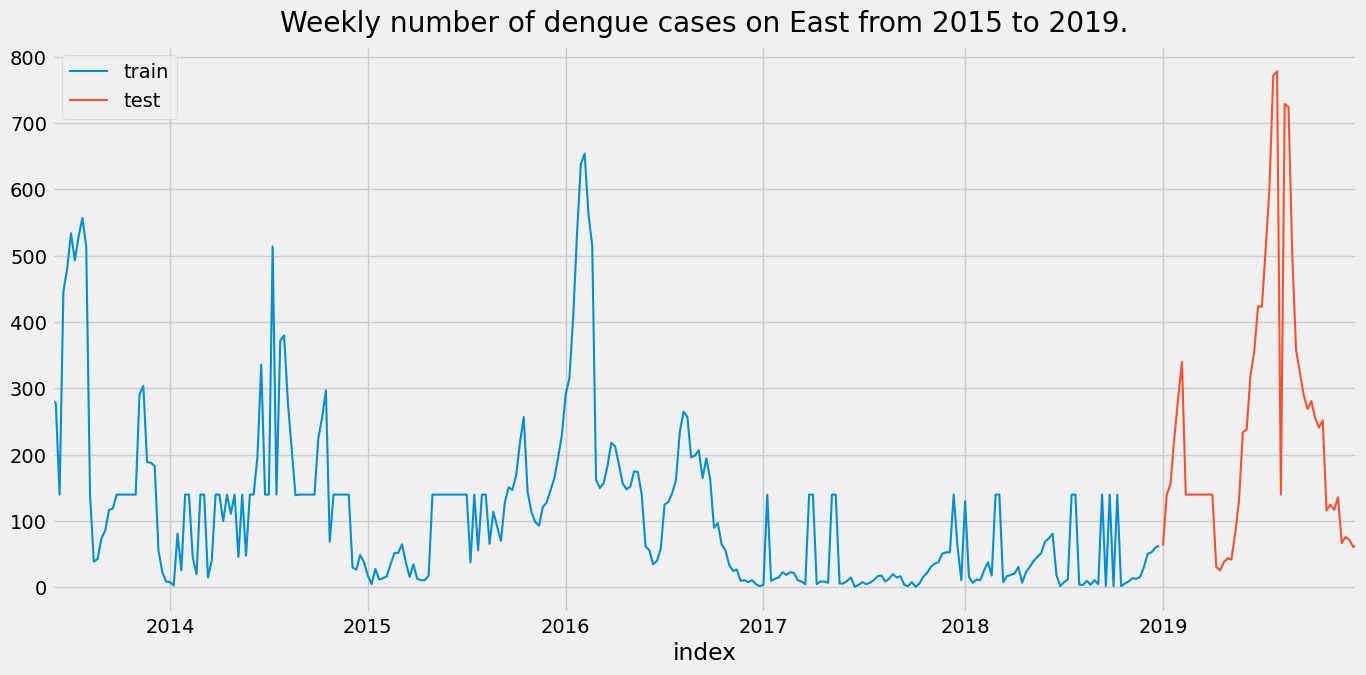

In [19]:
# Split data into train-test
# ==============================================================================
steps = 52
df_east_train = df_east[:-steps]
df_east_test  = df_east[-steps:]

print(f"Train dates : {df_east_train.index.min()} --- {df_east_train.index.max()}  (n={len(df_east_train)})")
print(f"Test dates  : {df_east_test.index.min()} --- {df_east_test.index.max()}  (n={len(df_east_test)})")

fig, ax = plt.subplots(figsize=(15, 7))
df_east_train['no_cases'].plot(ax=ax, label='train',title='Weekly number of dengue cases on East from 2015 to 2019.')
df_east_test['no_cases'].plot(ax=ax, label='test')
ax.legend();

ForecasterAutoreg   

With the ForecasterAutoreg class, a model is created and trained from a RandomForestRegressor regressor with a time window of 12 lags.

In [20]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

forecaster.fit(y=df_east_train['no_cases'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-06-02 00:00:00'), Timestamp('2018-12-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-29 06:51:44 
Last fit date: 2023-04-29 06:51:45 
Skforecast version: 0.7.0 
Python version: 3.11.0 
Forecaster

In [21]:
# Predictions
# ==============================================================================
steps = 52
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2019-01-06    57.24
2019-01-13    64.51
2019-01-20    70.03
2019-01-27    63.38
2019-02-03    67.06
Freq: W-SUN, Name: pred, dtype: float64

Text(0.5, 1.0, 'Prediction on the test set on the number of dengue cases in the East')

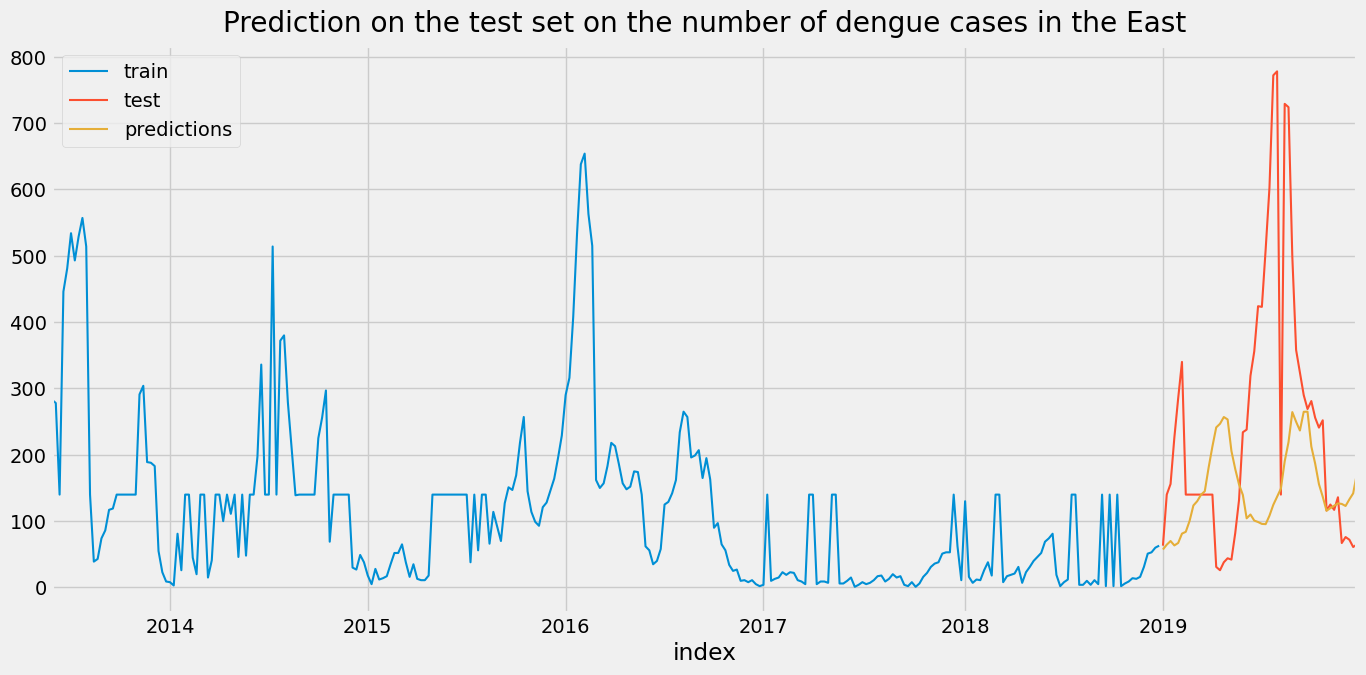

In [22]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 7))
df_east_train['no_cases'].plot(ax=ax, label='train')
df_east_test['no_cases'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
ax.set_xlim(df_east.index.min(), df_east.index.max());
plt.title('Prediction on the test set on the number of dengue cases in the East')

The error that the model makes in its predictions is quantified. In this case, the metric used is the mean squared error (mse).

In [23]:
# Test error
# ==============================================================================
error_mae = mean_absolute_error(
                y_true = df_east_test['no_cases'],
                y_pred = predictions
            )

error_mse = mean_squared_error(
                y_true = df_east_test['no_cases'],
                y_pred = predictions
            )

error_rmse = np.sqrt(
               error_mse
            )

print(f"Mean Absolute Error (MAE): {error_mae}")
print(f"Mean Squared Error (MSE)): {error_mse}")
print(f"Root Mean Squared Error (RMSE): {error_rmse}")

Mean Absolute Error (MAE): 153.0696153846154
Mean Squared Error (MSE)): 51173.38254615384
Root Mean Squared Error (RMSE): 226.21534551429937


Hyperparameter tuning
he trained ForecasterAutoreg uses a 12 lag time window and a Random Forest model with the default hyperparameters. However, there is no reason why these values are the most suitable. In order to identify the best combination of lags and hyperparameters, the Skforecast library provides the grid_search_forecaster function. It compares the results obtained with each model configuration.

In [24]:
# Hyperparameter Grid search
# ==============================================================================
steps = 52
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [1,3,6,10,12]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = df_east_train['no_cases'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(df_east_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 30.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [01:12<00:00, 14.43s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 6232.504590591869



Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 6232.504590591869

In [26]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 1
             )

forecaster.fit(y=df_east_train['no_cases'])

In [27]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

Text(0.5, 1.0, 'Prediction on the test set on the number of dengue cases in the East')

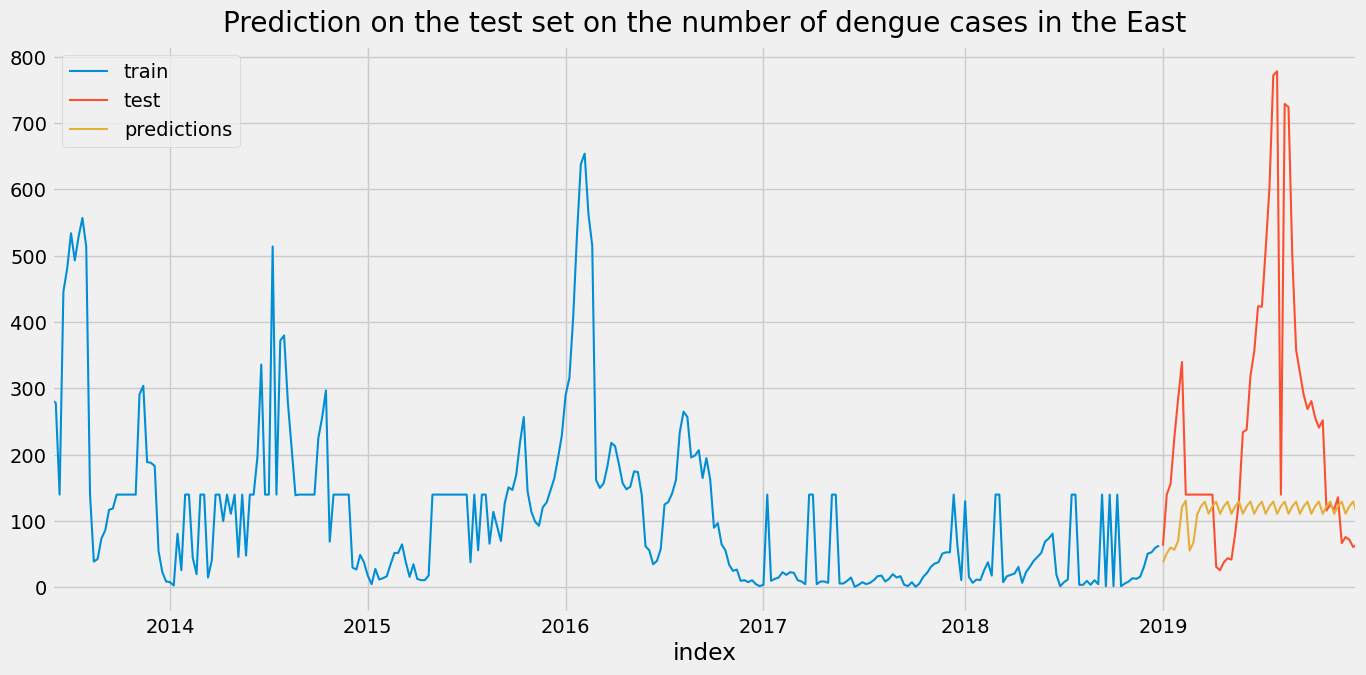

In [28]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 7))
df_east_train['no_cases'].plot(ax=ax, label='train')
df_east_test['no_cases'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
plt.title('Prediction on the test set on the number of dengue cases in the East')

Text(0.5, 1.0, 'Prediction on the test set on the number of dengue cases in the East based on Random Forest Model')

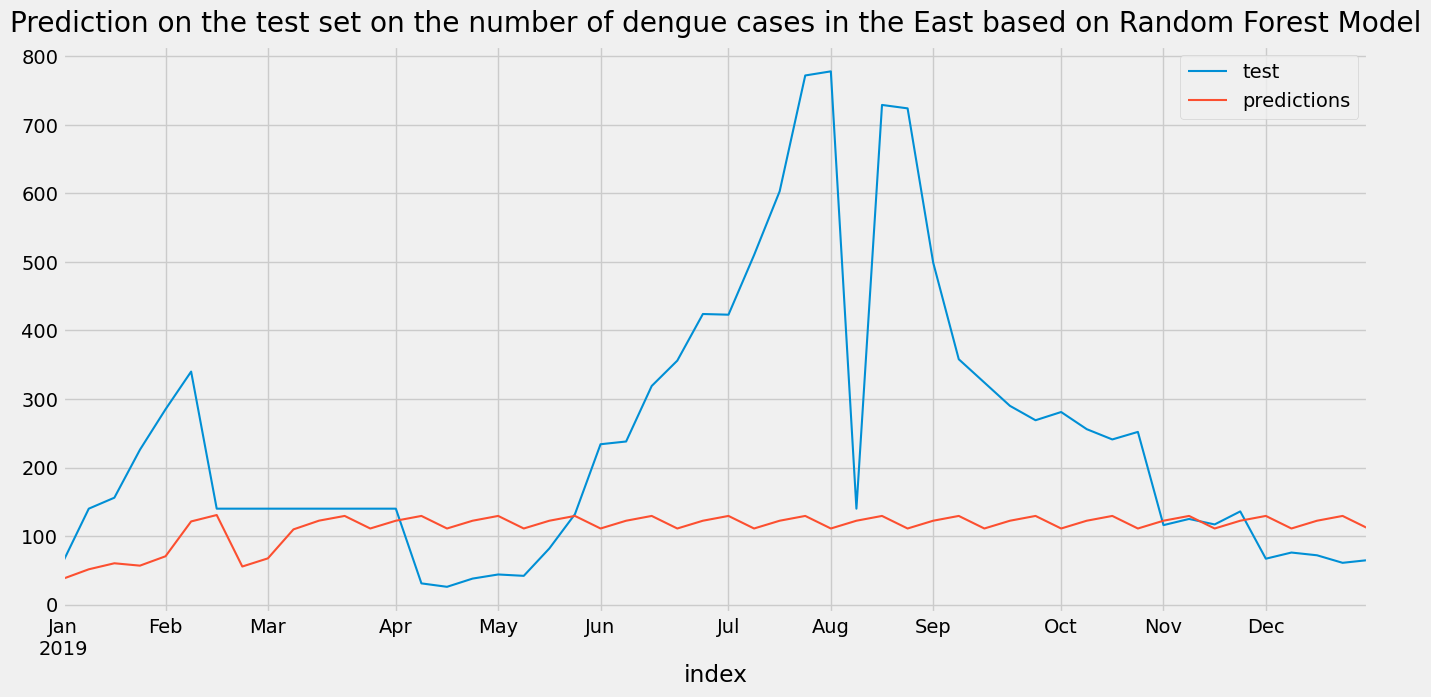

In [29]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 7))
# Remove the line that plots the train data
# df_east_train['no_cases'].plot(ax=ax, label='train')

df_east_test['no_cases'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Adjust the x-axis limits to show the data only from the test set's start date
ax.set_xlim(df_east_test.index.min(), df_east.index.max());

plt.title('Prediction on the test set on the number of dengue cases in the East based on Random Forest Model')

In [30]:
# Get train predictions
train_predictions = forecaster.predict(steps=len(df_east_train)-1, last_window=df_east_train['no_cases'].iloc[-1:])

# Compute the MAE, MSE, and RMSE between the predicted values and the actual values for the training set
train_mae = mean_absolute_error(df_east_train['no_cases'].iloc[1:], train_predictions)
train_mse = mean_squared_error(df_east_train['no_cases'].iloc[1:], train_predictions)
train_rmse = np.sqrt(train_mse)

print(f"Train Mean Absolute Error (MAE): {train_mae}")
print(f"Train Mean Squared Error (MSE): {train_mse}")
print(f"Train Root Mean Squared Error (RMSE): {train_rmse}")

Train Mean Absolute Error (MAE): 90.64547425420754
Train Mean Squared Error (MSE): 16259.850361769146
Train Root Mean Squared Error (RMSE): 127.51411828409098


In [31]:
# Test error
# ==============================================================================
error_mae = mean_absolute_error(
                y_true = df_east_test['no_cases'],
                y_pred = predictions
            )

error_mse = mean_squared_error(
                y_true = df_east_test['no_cases'],
                y_pred = predictions
            )

error_rmse = np.sqrt(
               error_mse
            )

print(f"Test Mean Absolute Error (MAE): {error_mae}")
print(f"Test Mean Squared Error (MSE)): {error_mse}")
print(f"Test Root Mean Squared Error (RMSE): {error_rmse}")

Test Mean Absolute Error (MAE): 157.86743696654054
Test Mean Squared Error (MSE)): 54967.47602455612
Test Root Mean Squared Error (RMSE): 234.4514363883406


The MAE indicates that, on average, your model's predictions are off by about 68 dengue cases. It calculates the average of the absolute differences between the predicted and actual values.

The RMSE, on the other hand, measures the average squared differences between the predicted and actual values and then takes the square root. This metric is more sensitive to large errors, as it squares the differences before averaging. In this case, the RMSE is about 74 dengue cases.

In summary, your model's predictions have an average error of about 68 dengue cases (according to MAE) or 74 dengue cases (according to RMSE). The choice between these two metrics depends on the specific problem and whether you want to give more weight to larger errors or not. In general, both values provide an estimate of the average error in your predictions.

In [32]:
# Backtesting
# ==============================================================================
steps = 52
n_backtesting = 52*3 # The last 9 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = df_east['no_cases'],
                                    initial_train_size = len(df_east) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    metric             = 'mean_squared_error',
                                    refit              = True,
                                    verbose            = True
                                )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 188
Number of observations used for backtesting: 156
    Number of folds: 3
    Number of steps per fold: 52

Data partition in fold: 0
    Training:   2013-06-02 00:00:00 -- 2017-01-01 00:00:00  (n=188)
    Validation: 2017-01-08 00:00:00 -- 2017-12-31 00:00:00  (n=52)
Data partition in fold: 1
    Training:   2013-06-02 00:00:00 -- 2017-12-31 00:00:00  (n=240)
    Validation: 2018-01-07 00:00:00 -- 2018-12-30 00:00:00  (n=52)
Data partition in fold: 2
    Training:   2013-06-02 00:00:00 -- 2018-12-30 00:00:00  (n=292)
    Validation: 2019-01-06 00:00:00 -- 2019-12-29 00:00:00  (n=52)

Backtest error: 23578.92677034338


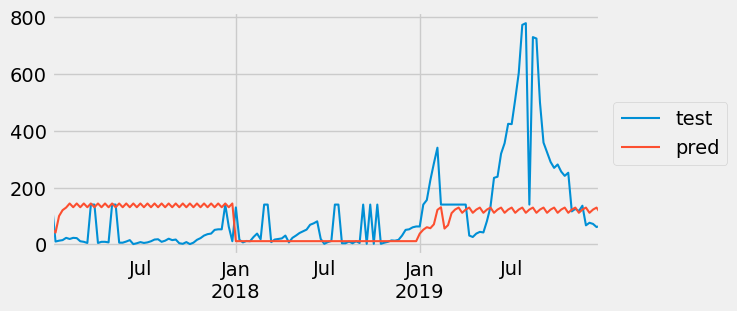

In [33]:
fig, ax = plt.subplots(figsize=(7, 3))
df_east.loc[predictions_backtest.index, 'no_cases'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

# Add a legend
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))